## Full data prediction (for *Data-driven prediction of battery cycle life before capacity degradation*)
### Time-series version

##### The goal is to check whether self-organizing map (SOM) can be used to predict the cycle life of battery based on the "discharge capacity vs. cycle" curves.

Import all packages:

In [1]:
%matplotlib inline

import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
from sklearn.model_selection import train_test_split

from minisom import MiniSom

*Note: If section 1 and 2 are already runned before, there is no need to run them again. You can skip to section 3.*

### 1. Load and save the data


We load and select the raw data and save as a pickle file for easy access later.
#
There are 140 raw data in total in .json format. We only save the data of cycle index and discharge capacity since we only need them using the self-organizing map method of prediction. We remove the first and last data of discharge capacity for each cell since they are unreasonably very large. We also remove the outliers in the data (which are also unreasonably too large discharge capacities) and the cell with empty data.

In [2]:
files = glob.glob("FastCharge/*.json")
full_data = {}

for file in tqdm(files, desc="Processing files"):
    with open(file, "r") as f:
        data = pd.read_json(f)
        cycle_data = data.loc['cycle_index', 'summary']
        discharge_capacity_data = data.loc['discharge_capacity', 'summary']

        # Remove (make modifications to) the outliers
        cycle_data = cycle_data[1:-1]
        discharge_capacity_data = discharge_capacity_data[1:-1]
        Q1 = pd.Series(discharge_capacity_data).quantile(0.25)
        Q3 = pd.Series(discharge_capacity_data).quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        for i in range(1, len(discharge_capacity_data)):
            if discharge_capacity_data[i] > upper_bound:
                discharge_capacity_data[i] = discharge_capacity_data[i - 1]
    
    if len(cycle_data) > 0:
        full_data[file] = {'cycle': cycle_data, 'discharge_capacity': discharge_capacity_data}

df = pd.DataFrame.from_dict(full_data, orient='index')
df.reset_index(drop=True, inplace=True)
df.to_pickle("full_data_som.pkl")

Processing files: 100%|██████████| 140/140 [02:00<00:00,  1.16it/s]


### 2. Preprocessing data

In [3]:
# Load the saved data
full_data = pd.read_pickle("full_data_som.pkl")

We can first visualize data:

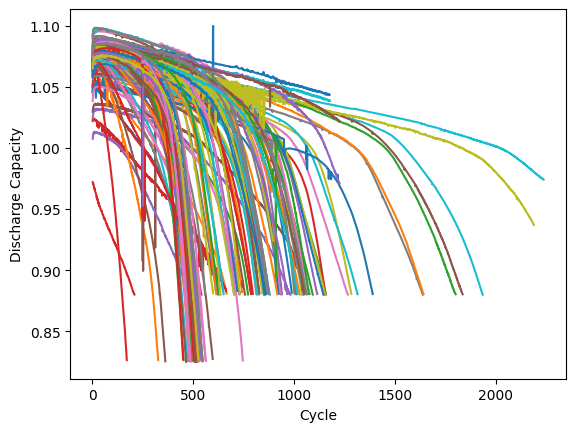

In [4]:
for index, row in full_data.iterrows():
    plt.plot(row['cycle'], row['discharge_capacity'], label=f"File {index + 1}")

plt.xlabel('Cycle')
plt.ylabel('Discharge Capacity')
plt.show()

We noticed that the all curves are noisy, so we apply Savitzky-Golay filter (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) with the length of the filter window (i.e., the number of coefficients) to be 71 and the order of the polynomial used to fit the samples to be 2 just as in *Stability follows efficiency based on the analysis of a large perovskite solar cells ageing dataset*.

In [5]:
full_data_filtered = full_data.copy()

for index, row in full_data_filtered.iterrows():
    row['discharge_capacity'] = savgol_filter(row['discharge_capacity'], 71, 2)

Visualize the filtered data now:

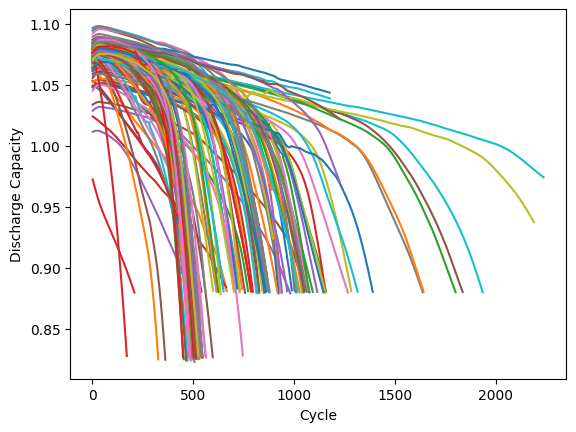

In [6]:
for index, row in full_data_filtered.iterrows():
    plt.plot(row['cycle'], row['discharge_capacity'], label=f"File {index + 1}")

plt.xlabel('Cycle')
plt.ylabel('Discharge Capacity')
plt.show()

Since all the cells have a nominal capacity of 1.1 Ah, for easy processing later, we normalize all the data by a factor of 1.1.

In [7]:
full_data_filtered_normalized = full_data_filtered.copy()

for index, row in full_data_filtered_normalized.iterrows():
    row['discharge_capacity'] = row['discharge_capacity'] / 1.1

Visualize the filtered and normalized data:

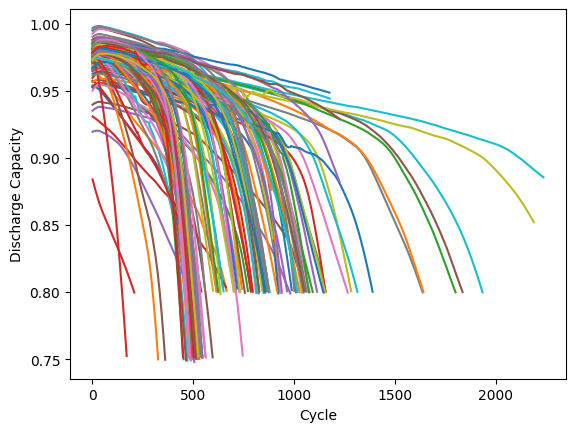

In [8]:
for index, row in full_data_filtered_normalized.iterrows():
    plt.plot(row['cycle'], row['discharge_capacity'], label=f"File {index + 1}")

plt.xlabel('Cycle')
plt.ylabel('Discharge Capacity')
plt.show()

We notice that some cells are terminated before the discharge capacity reaches 80% of the nominal value, so we will exclude those from the data set.

In [9]:
# Extract the final values after normalization
final_discharge_capacity_values = full_data_filtered_normalized['discharge_capacity'].apply(lambda x: x[-1])

# Exclude rows where the final value is higher than 0.81
filtered_indices = final_discharge_capacity_values <= 0.81
filtered_data = full_data_filtered_normalized[filtered_indices]

Visualize the final filtered data:

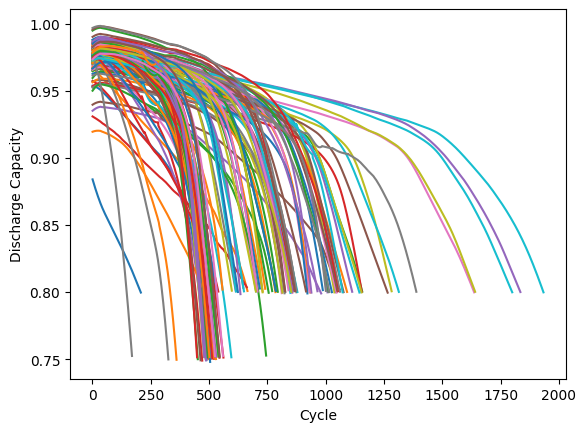

In [10]:
for index, row in filtered_data.iterrows():
    plt.plot(row['cycle'], row['discharge_capacity'], label=f"File {index + 1}")

plt.xlabel('Cycle')
plt.ylabel('Discharge Capacity')
plt.show()

We will now identify the cycle at which discharge_capacity is closest to 0.8 for each cell, which is defined as the cycle life of the battery.

In [11]:
closest_cycle_to_0_8 = []

for index, row in filtered_data.iterrows():
    closest_index = np.argmin(np.abs(np.array(row['discharge_capacity']) - 0.8))
    closest_cycle = row['cycle'][closest_index]
    closest_cycle_to_0_8.append(closest_cycle)

# Add the closest cycle to 0.8 for each cell to the data frame as the cycle life
filtered_data['cycle_life'] = closest_cycle_to_0_8
filtered_data.reset_index(drop=True, inplace=True)

C:\Users\shuan\AppData\Local\Temp\ipykernel_11904\165037786.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cycle_life'] = closest_cycle_to_0_8


Check the finalized data frame:

In [12]:
filtered_data

,cycle,discharge_capacity,cycle_life
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.953703841954174, 0.9536596591653699, 0.9536...",461
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9669830175603225, 0.9668087158173615, 0.966...",665
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9717707580844134, 0.9716887233721967, 0.971...",771
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.957341987570086, 0.9572384230968206, 0.9571...",540
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9715489228538523, 0.971663768128656, 0.9717...",1008
...,...,...,...
122,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9758531125386598, 0.9760291926857941, 0.976...",510
123,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9744196508047869, 0.9745869958873203, 0.974...",486
124,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9824553724033698, 0.9826981606038051, 0.982...",458
125,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9825660352229605, 0.9827452884687115, 0.982...",519


Save the finalized data frame as a pickle file for easier access later:

In [13]:
filtered_data.to_pickle("full_data_filtered_som.pkl")

### 3. Divide the data into the train set and the test set
Since we want to predict the cycle life of the battery using only the first 100 cycles of testing, we will define the input X as the discharge capacity of the first 100 cycles of testing and y as the cycle life. Recall that for the self-organizing map, the train set is used to train the model to build different clusters (according to different kinds of shapes of the "discharge capacity vs. cycle" curves), and then get the averaged cycle life ($\bar y$) for each cluster. When it comes to the test set, we identify which cluster each belongs to according to each one's "discharge capacity vs. cycle" curve, and utilize the averaged cycle life of the identified cluster obtained before to predict the cycle life of the one in the test set.
We make 80% of the data to be the train set and the rest (20%) to be the test set.

In [14]:
# Load the saved data
filtered_data = pd.read_pickle("full_data_filtered_som.pkl")

In [15]:
train_cycle_size = 100

discharge = filtered_data['discharge_capacity']

X = np.zeros((filtered_data.shape[0], train_cycle_size))
for i in range(filtered_data.shape[0]):
    X[i][:] = discharge.iloc[i][0:train_cycle_size]

y = filtered_data['cycle_life'].values

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (101, 100)
X_test shape: (26, 100)
y_train shape: (101,)
y_test shape: (26,)


### 4. Apply self-organizing map (SOM) on the train set
When applying SOM, the $\sigma$, which is the radius of the different neighbors in the SOM, is set to $0.5$, and the learning rate is set to $0.1$. We will use $5^2=25$ clusters.

In [16]:
# Set up sigma and learning_rate
sigma = 0.5
learning_rate= 0.1

# Set the number of clusters
som_x = 5
som_y = 5

# Calculate the SOM for the train set
som = MiniSom(som_x, som_y, train_cycle_size, sigma=sigma, learning_rate = learning_rate)
som.random_weights_init(X_train)
som.train(X_train, 50000, verbose=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.008232243396906867


In [17]:
# Find out which row in the train set belongs to which cluster
som_shape = (som_x,som_y)
winner_coordinates_train = np.array([som.winner(x) for x in X_train]).T

# With np.ravel_multi_index we convert the 2-dimensional coordinates to a 1-dimensional index
cluster_index_unfixed_train = np.ravel_multi_index(winner_coordinates_train, som_shape)

# Find the mean of cycle life for each cluster
y_cluster = np.zeros(som_x*som_y)
for i in range(som_x*som_y):
    y_classified = np.empty(0)
    for j in range(X_train.shape[0]):
        if cluster_index_unfixed_train[j] == i:
            y_classified = np.append(y_classified, y_train[j])
    y_cluster[i] = np.mean(y_classified)

c:\Users\shuan\miniconda3\envs\ml\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shuan\miniconda3\envs\ml\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### 5. Using the trained SOM to predict the cycle life each battery cell from the test set

In [18]:
# Find out which row in the test set belongs to which cluster
winner_coordinates_test = np.array([som.winner(x) for x in X_test]).T

# With np.ravel_multi_index we convert the 2-dimensional coordinates to a 1-dimensional index
cluster_index_unfixed_test = np.ravel_multi_index(winner_coordinates_test, som_shape)

# Predict using the information of the time series of averaged PCE of the identified cluster
y_predict = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    y_predict[i] = y_cluster[cluster_index_unfixed_test[i]]

Visualize the predicting results:

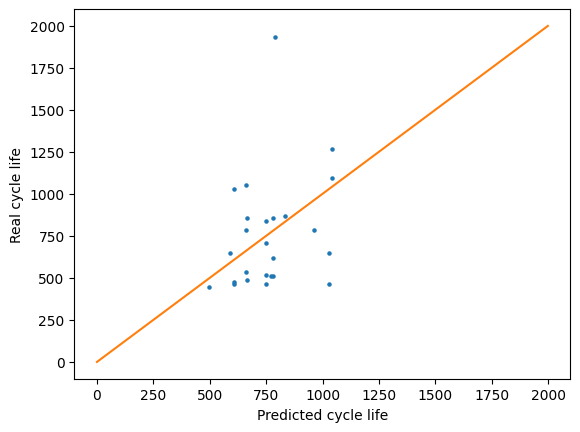

In [19]:
plt.figure()
plt.scatter(y_predict, y_test, s=5)
plt.plot(range(0,2000),range(0,2000), color='C1')
plt.xlabel('Predicted cycle life')
plt.ylabel('Real cycle life')
plt.show()

The main possible reason for the inaccuracy in the predicted cycle life is that the samples (train set) is too small (only around 100 samples).
#
If we try to decrease or increase the number of clusters (use $i^2$ clusters where $i=2,3,4,5,6,7$):

Iteration No. 1
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.048523856581856185
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.023511021178292114
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.0166455040768405
 [  4251 / 50000 ]   9% - 0:00:01 left 

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.011778992895400048
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.007288166140849939
 [  3161 / 50000 ]   6% - 0:00:01 left 

c:\Users\shuan\miniconda3\envs\ml\Lib\site-packages\minisom.py:536: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.00749413336739603
Iteration No. 2
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.05146593099164544
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.02456677706500797
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.018119881772566116
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.013096358277638092
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.0059839604867333775
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.0045914897394421774
Iteration No. 3
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.047807623782396745
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.02741935503212628
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.016001090904102133
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.009763410391249793
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.00547

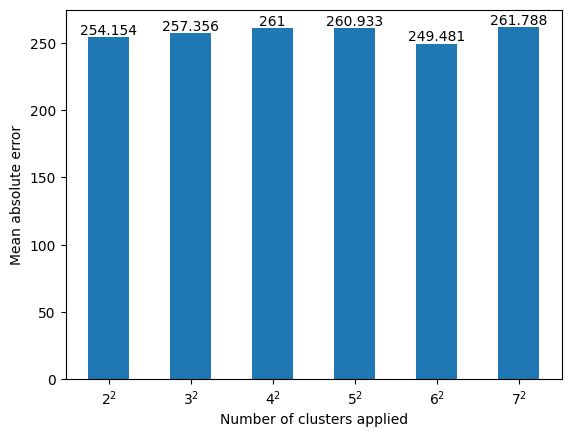

In [20]:
error_total = np.zeros((10,6))

# We run the test for 10 times and take the average to ensure the accuracy of the result
for m in range(10):
    print('Iteration No.',m+1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    for k in range(2,8):
        # Set the number of clusters
        som_x = k
        som_y = k

        # Calculate the SOM for the train set
        som = MiniSom(som_x, som_y, train_cycle_size, sigma=sigma, learning_rate = learning_rate)
        som.random_weights_init(X_train)
        som.train(X_train, 50000, verbose=True)

        # Find out which row in the train set belongs to which cluster
        som_shape = (som_x,som_y)
        winner_coordinates_train = np.array([som.winner(x) for x in X_train]).T

        # With np.ravel_multi_index we convert the 2-dimensional coordinates to a 1-dimensional index
        cluster_index_unfixed_train = np.ravel_multi_index(winner_coordinates_train, som_shape)

        # Find the mean of cycle life for each cluster
        y_cluster = np.zeros(som_x*som_y)
        for i in range(som_x*som_y):
            y_classified = np.empty(0)
            for j in range(X_train.shape[0]):
                if cluster_index_unfixed_train[j] == i:
                    y_classified = np.append(y_classified, y_train[j])
            y_cluster[i] = np.mean(y_classified)

        # Find out which row in the test set belongs to which cluster
        winner_coordinates_test = np.array([som.winner(x) for x in X_test]).T

        # With np.ravel_multi_index we convert the 2-dimensional coordinates to a 1-dimensional index
        cluster_index_unfixed_test = np.ravel_multi_index(winner_coordinates_test, som_shape)

        # Predict using the information of the time series of averaged PCE of the identified cluster
        y_predict = np.zeros(X_test.shape[0])
        error = np.zeros(X_test.shape[0])
        for i in range(X_test.shape[0]):
            y_predict[i] = y_cluster[cluster_index_unfixed_test[i]]
            error[i] = np.abs(y_predict[i] - y_test[i])
        
        error_total[m,k-2] = np.nanmean(error)

# Plot the mean absolute error for different number of clusters
plt.figure()
bars=plt.bar([r'$2^2$',r'$3^2$',r'$4^2$',r'$5^2$',r'$6^2$',r'$7^2$'], np.nanmean(error_total, axis=0), width = 0.5)
plt.xlabel('Number of clusters applied')
plt.ylabel('Mean absolute error')
plt.bar_label(bars)
plt.show()

*Mean absolute error is in the unit of cycles.*
#
No clear difference (trend) between different number of clusters. Prediction is still poor.
#
**In this case (samples are not large), it is better to predict using features instead of time series.**